In [1]:
%matplotlib notebook

import SimpleITK as sitk
#import itkwidgets
import os, glob, re, math, sys

In [2]:
import filebrowser

f=filebrowser.FileBrowser()
print("Select an image from a series")
f.widget()

Select an image from a series


In [3]:
# strip off the last 7 characters (###.tif) and replace with *.tif
search_string = f.path[:-7]+'*.tif'
search_string

'/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned*.tif'

In [4]:
import load_slices
slices = load_slices.load_slices(search_string)

/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned000.tif
  ...
/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned161.tif
162 files
Image width = 1008
Binning by 1
(0, 0, 1008, 653)
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 Loaded files: ['/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned000.tif', '/Users/dave/Box Sync/Microscopy/milling/SilicaBeadsPre-aligned/crop/Silicabeads_aligned001.tif

<IPython.core.display.Javascript object>


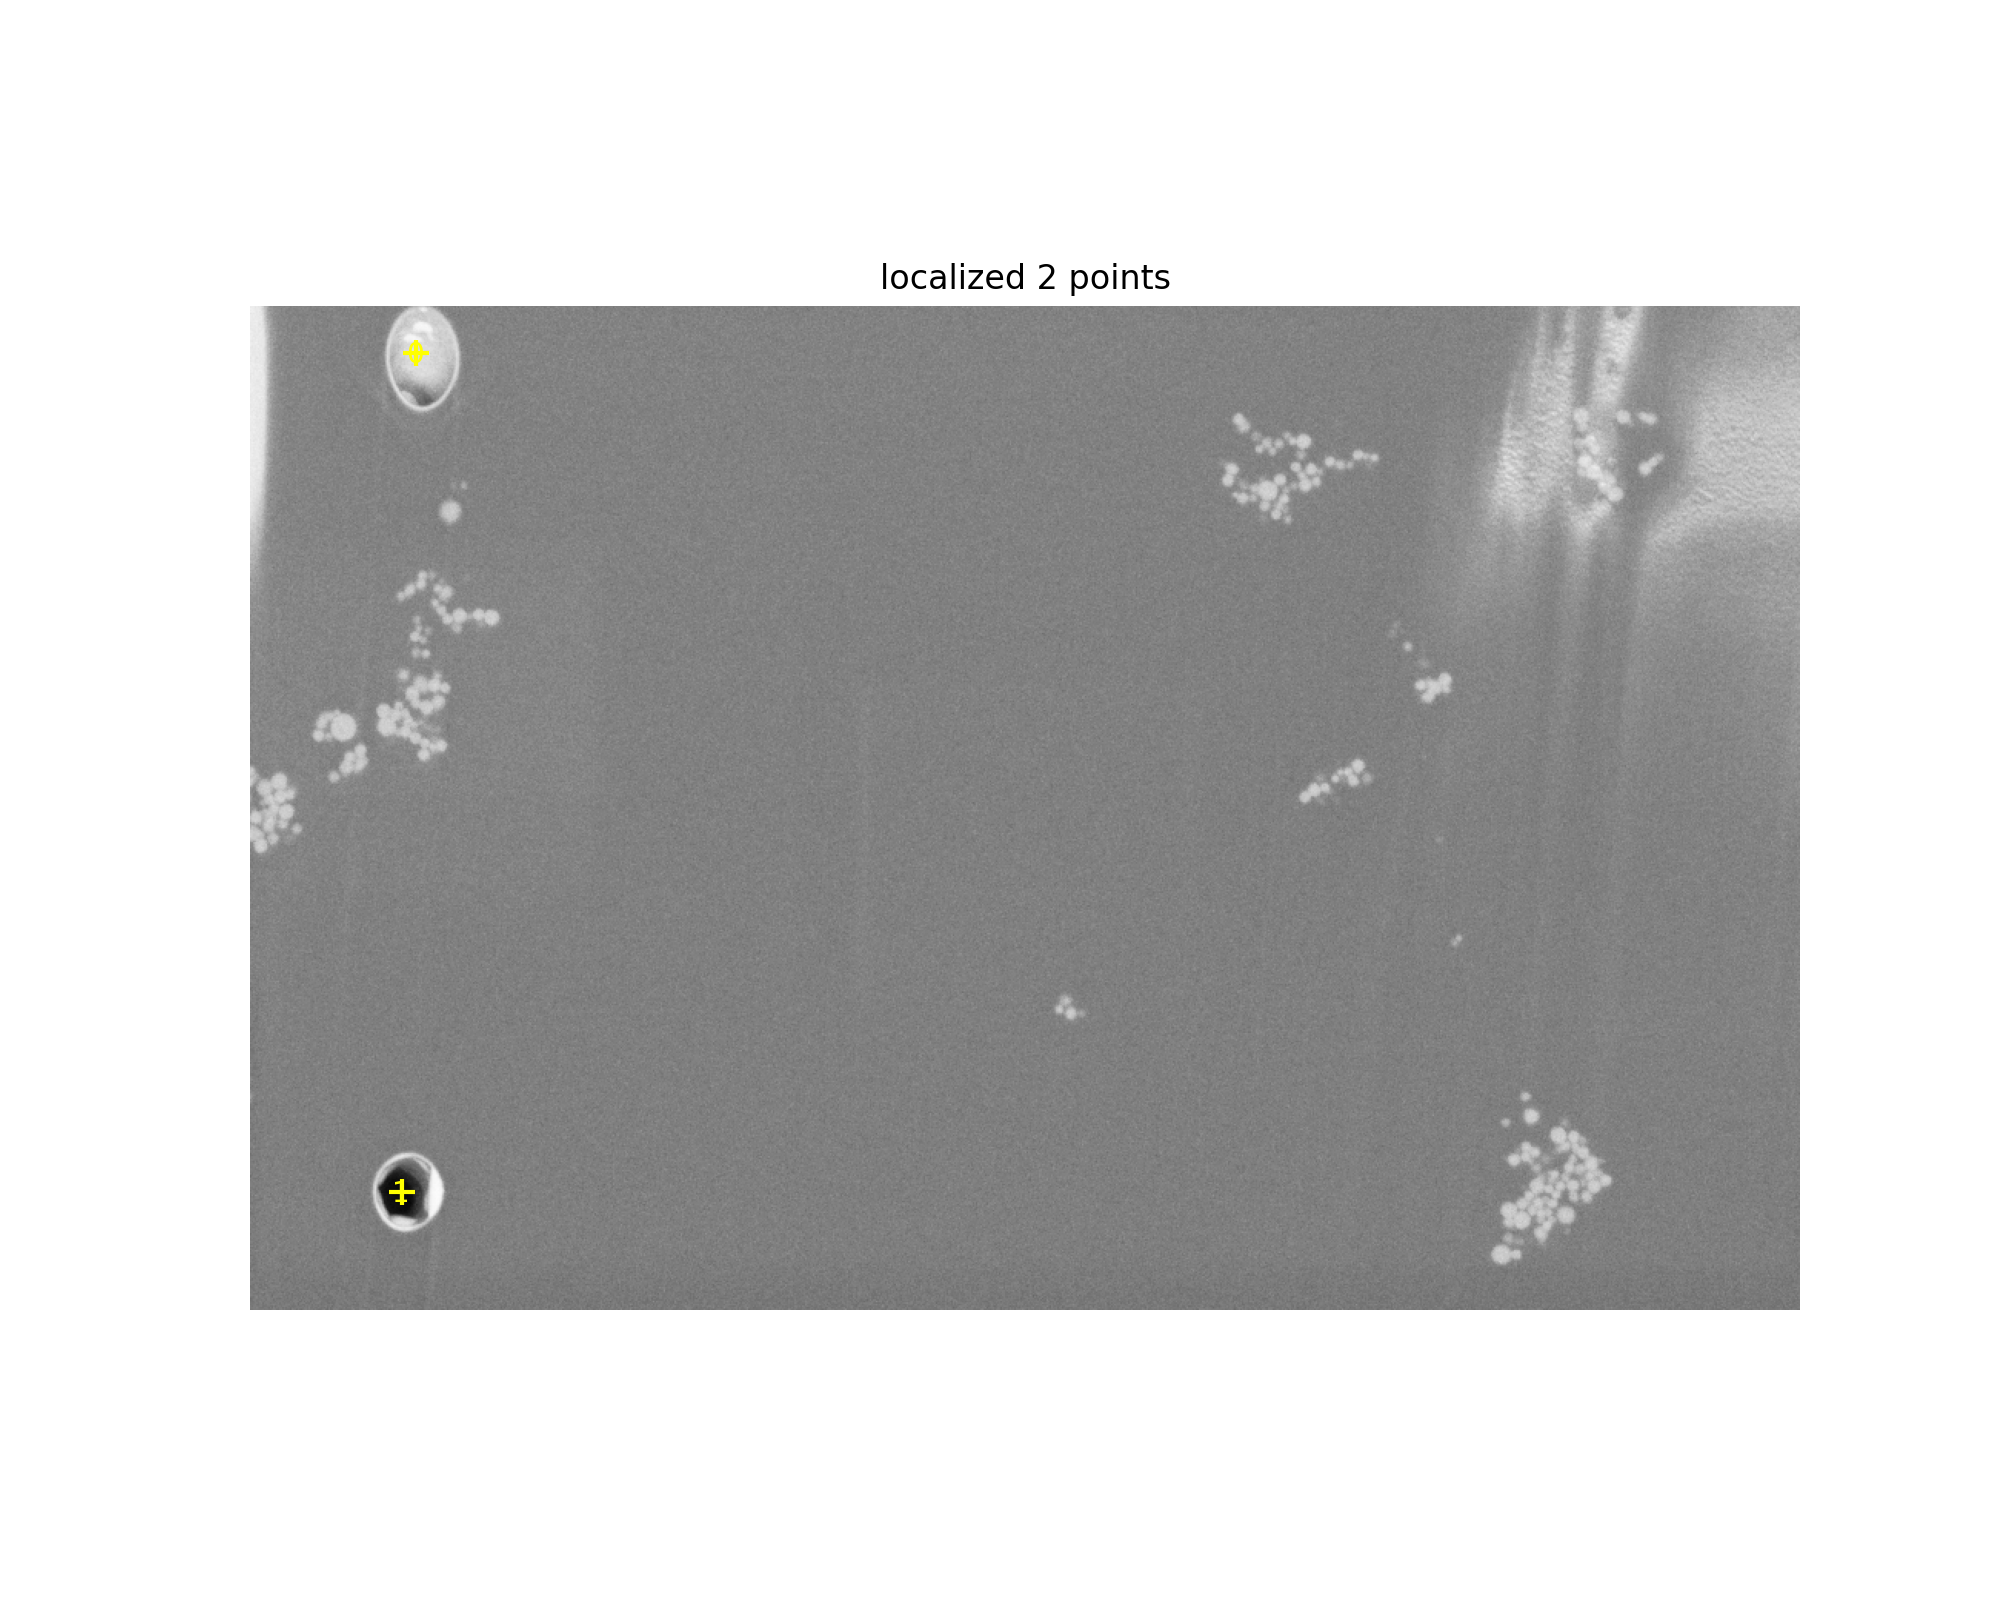

In [5]:
import gui
v = sitk.JoinSeries(slices)

acquire_centers = gui.PointDataAquisition(v)

In [6]:
import itkwidgets
itkwidgets.view(v, mode='z', cmap='Grayscale')

Viewer(cmap='Grayscale', geometries=[], gradient_opacity=0.22, mode='z', point_sets=[], rendered_image=<itkIma…

In [7]:
import segment

bg = segment.segmentSeriesBackgrounds(slices)

v = sitk.JoinSeries(bg) * 255
itkwidgets.view(v, mode='z', cmap='Grayscale')

Viewer(cmap='Grayscale', geometries=[], gradient_opacity=0.22, mode='z', point_sets=[], rendered_image=<itkIma…

In [9]:
seeds=[]
first_z = 0
picked_seeds = acquire_centers.get_point_indexes()
if len(picked_seeds) != 2:
    print("Warning: there should be two seed points")
    if picked_seeds[0][2] != picked_seeds[1][2]:
        print("Warning: the two seeds are on different slices, using the larger of the two.")
else:
    print(picked_seeds)

    # transform the picked seeds to physical space
    first_z = max(picked_seeds[0][2], picked_seeds[1][2])
    first_bg = bg[first_z]
    for seed in picked_seeds:
        seed_tf = first_bg.TransformIndexToPhysicalPoint(seed[0:2])
        seeds.append(seed_tf)
    print(seeds)

[(108, 30, 0), (98, 575, 0)]
[(648.0000340619443, 180.0000094616512), (588.0000309080606, 3450.0001813483145)]


In [10]:
# Locations of the two holes in physical space
# These seeds sets are used if the interactive seed picking above didn't happen.

# seeds for initial test data set: /Slice & View 01-31/Images/SEM Image
if len(seeds) == 0:
    seeds=[[962,1641],[5293,1660]]

# seeds for 2/18 data set: Slice & View 02-18/Images/SEM Multi-Detector Image
if len(seeds) == 0:
    seeds = [ [678, 216], [618,3456]]

In [11]:
import track_hole

radius = 500

all_ellipses = []
snum=0
for seed in seeds:
    seed_ellipses = track_hole.track_hole(seed, bg, first_z)
    all_ellipses.extend(seed_ellipses)
#print(all_ellipses)

UnboundLocalError: local variable 'snum' referenced before assignment

In [ ]:
import numpy as np
def ellipses2pointset(elist):
    """ convert ellipse centers to a numpy array """
    centers = []
    for e in elist:
        c = e[0]
        centers.append(c)
    np_points = np.array(centers)
    return np_points

In [ ]:
pts = ellipses2pointset(all_ellipses)
#print(pts)

In [ ]:
itkwidgets.view(v, mode='z', cmap='Grayscale',point_sets=[pts])

In [ ]:
import ipywidgets as widgets
w = widgets.Text(
    value='',
    description='Output file'
)
display(w)

In [ ]:
print (w.value)

In [ ]:
#import importlib
import output
#importlib.reload(output)
output.write_results(all_ellipses, w.value)